# Linear Regression
Used to predict a numeric value

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

2024-01-29 19:42:23.258054: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 19:42:23.258169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 19:42:23.269252: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 19:42:23.305846: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-29 19:42:24.427575: W tensorflow/compiler/tf2

### Linear Regression Visualization
Just a graph demonstrating 2-d linear regression

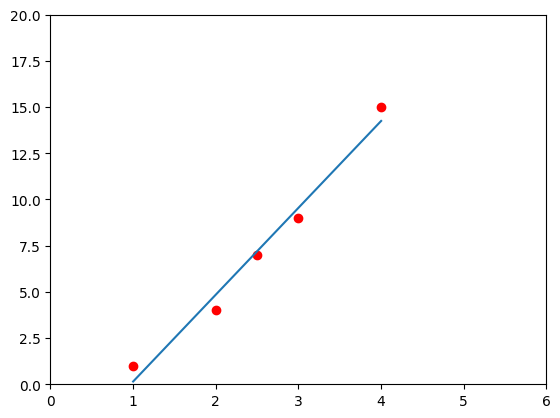

In [2]:
x = [1, 2, 2.5, 3, 4]
y = [1, 4, 7, 9, 15]
plt.plot(x, y, 'ro')
plt.axis([0, 6, 0, 20])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.show()

### Lets play with the data

Here we will actually grab sample training data from Tensorflow's website and play with it

In [3]:
# Load dataset
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique() # gets a list of all unique values from given feature column
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))
    
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))
    
print(feature_columns)

print(dftrain.loc[0], y_train.loc[0])

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', 

In [4]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [5]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


<Axes: >

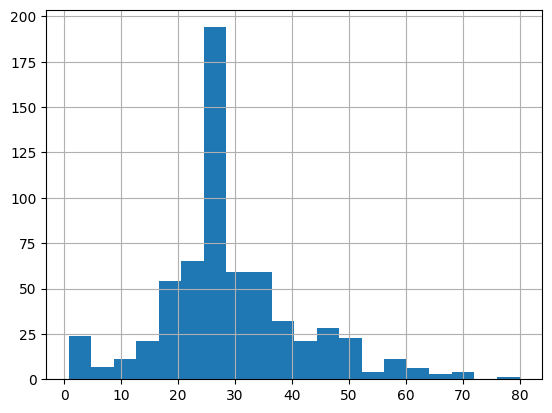

In [6]:
dftrain.age.hist(bins=20)

<Axes: ylabel='sex'>

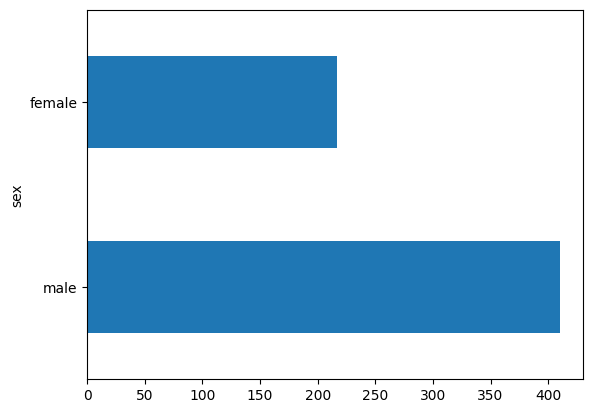

In [7]:
dftrain.sex.value_counts().plot(kind='barh')

<Axes: ylabel='class'>

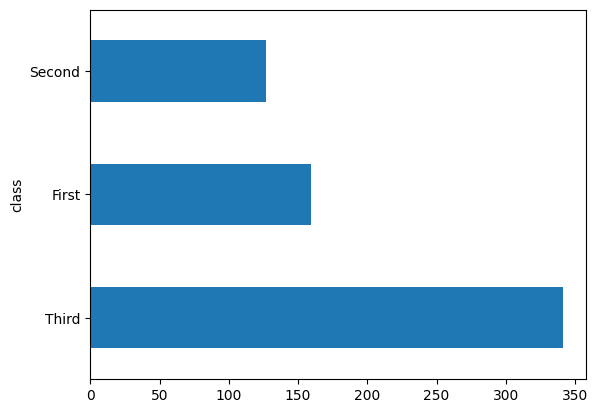

In [8]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

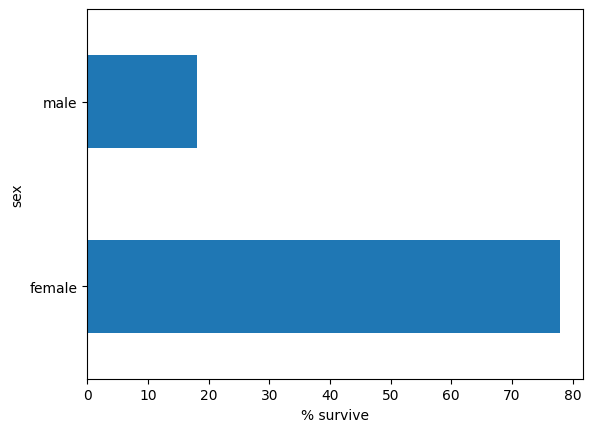

In [9]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().multiply(100).plot(kind='barh').set_xlabel("% survive")

In [10]:
dfeval.shape

(264, 9)

In [11]:
dftrain.shape

(627, 9)

In [12]:
dftrain["embark_town"].unique()

array(['Southampton', 'Cherbourg', 'Queenstown', 'unknown'], dtype=object)

### Ok, now we're going to actually train it

In [13]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
        return ds  # return a batch of the dataset
    return input_function  # return functor

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the functor
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result['accuracy'])
print(result)

0.75757575
{'accuracy': 0.75757575, 'accuracy_baseline': 0.625, 'auc': 0.83501685, 'auc_precision_recall': 0.7822714, 'average_loss': 0.4914527, 'label/mean': 0.375, 'loss': 0.48197052, 'precision': 0.721519, 'prediction/mean': 0.3050835, 'recall': 0.57575756, 'global_step': 200}


#### Try with twice as many epochs

In [14]:
train_input_fn = make_input_fn(dftrain, y_train, num_epochs=20)  # here we will call the functor
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result['accuracy'])
print(result)

0.75757575
{'accuracy': 0.75757575, 'accuracy_baseline': 0.625, 'auc': 0.8315887, 'auc_precision_recall': 0.80210096, 'average_loss': 0.4880042, 'label/mean': 0.375, 'loss': 0.47898567, 'precision': 0.6666667, 'prediction/mean': 0.43772894, 'recall': 0.7070707, 'global_step': 400}


#### predict now

In [15]:
result = list(linear_est.predict(eval_input_fn))
for i in range(len(result)):
    print(dfeval.loc[i])
    print(str(result[i]['probabilities'][1] * 100) + "% chance of survival")
    print(os.linesep)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmph6vyxyhe/model.ckpt-400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2024-01-29 19:43:07.285594: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 19:43:07.285686: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 19:43:07.285717: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 19:43:07.285883: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 19:43:07.285911: I tensorflow/core/common_runtime/gpu/gpu

sex                          male
age                          35.0
n_siblings_spouses              0
parch                           0
fare                         8.05
class                       Third
deck                      unknown
embark_town           Southampton
alone                           y
Name: 0, dtype: object
11.07654795050621% chance of survival


sex                          male
age                          54.0
n_siblings_spouses              0
parch                           0
fare                      51.8625
class                       First
deck                            E
embark_town           Southampton
alone                           y
Name: 1, dtype: object
55.476146936416626% chance of survival


sex                        female
age                          58.0
n_siblings_spouses              0
parch                           0
fare                        26.55
class                       First
deck                            C
embark_town           S

2024-01-29 19:43:07.900296: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17068575892714832295
2024-01-29 19:43:07.900336: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 143954360124686765
2024-01-29 19:43:07.900345: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4122251874121317951
2024-01-29 19:43:07.900350: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12262819397112685921
2024-01-29 19:43:07.900356: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13084055022067390525
2024-01-29 19:43:07.900360: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16694750484287121915
2024-01-29 19:43:07.900365: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv 

# Classification
Used to separate data points into classes of different labels

### Dataset
This dataset separates flowers into 3 different classes of species.

- Setosa
- Versicolor
- Virginica

The information about each flower is the following:

- sepal length
- sepal width
- petal length
- petal width

In [16]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']

In [17]:
train_path = tf.keras.utils.get_file("iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file("iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")
train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)

Let's look at the data

In [18]:
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [19]:
train_y = train.pop('Species')
test_y = test.pop('Species')
train.head() # the species column is gone since we popped it

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


In [20]:
train.shape

(120, 4)

### Input Function

In [21]:
def input_fn(features, labels, training=True, batch_size=256):
    # Converts the input to a dataset
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    
    if training:
        dataset = dataset.shuffle(1000).repeat()
        
    return dataset.batch(batch_size)

### Feature Columns

In [22]:
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
print(my_feature_columns)

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


### Building the model
For classification tasks there are a variety of different estimators, models that we can pick from.  Some options are listed below:
* DNNClassifier (Deep Neural Network)
* LinearClassifier
We can choose either model but DNN seems like the best choice since we may not be able to find a linear coorespondence in our data

In [23]:
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    hidden_units=[30, 10],
    n_classes=3)

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpbv3znkgv', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_work

### Training the model

In [24]:
classifier.train(input_fn=lambda: input_fn(train, train_y, training=True), steps=5000)

Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpbv3znkgv/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


2024-01-29 19:43:08.457695: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 19:43:08.457792: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 19:43:08.457822: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 19:43:08.458034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 19:43:08.458061: I tensorflow/core/common_runtime/gpu/gpu

INFO:tensorflow:loss = 2.1906385, step = 0
INFO:tensorflow:global_step/sec: 189.615
INFO:tensorflow:loss = 1.4012412, step = 100 (0.528 sec)
INFO:tensorflow:global_step/sec: 202.067
INFO:tensorflow:loss = 1.2288017, step = 200 (0.496 sec)
INFO:tensorflow:global_step/sec: 239.052
INFO:tensorflow:loss = 1.1348622, step = 300 (0.418 sec)
INFO:tensorflow:global_step/sec: 234.998
INFO:tensorflow:loss = 1.0753188, step = 400 (0.426 sec)
INFO:tensorflow:global_step/sec: 238.852
INFO:tensorflow:loss = 1.0604655, step = 500 (0.418 sec)
INFO:tensorflow:global_step/sec: 247.396
INFO:tensorflow:loss = 1.0266573, step = 600 (0.404 sec)
INFO:tensorflow:global_step/sec: 240.945
INFO:tensorflow:loss = 0.9919574, step = 700 (0.416 sec)
INFO:tensorflow:global_step/sec: 235.102
INFO:tensorflow:loss = 0.9879016, step = 800 (0.425 sec)
INFO:tensorflow:global_step/sec: 252.998
INFO:tensorflow:loss = 0.9686518, step = 900 (0.395 sec)
INFO:tensorflow:global_step/sec: 217.936
INFO:tensorflow:loss = 0.9549436, 

In [25]:
eval_result = classifier.evaluate(input_fn=lambda: input_fn(train, train_y, training=False))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2024-01-29T19:43:29
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbv3znkgv/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2024-01-29 19:43:29.727350: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 19:43:29.727465: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 19:43:29.727499: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 19:43:29.727741: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 19:43:29.727757: I tensorflow/core/common_runtime/gpu/gpu

INFO:tensorflow:Inference Time : 0.75835s
INFO:tensorflow:Finished evaluation at 2024-01-29-19:43:30
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.7583333, average_loss = 0.65477794, global_step = 5000, loss = 0.65477794
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmpbv3znkgv/model.ckpt-5000

Test set accuracy: 0.758



### User test

In [26]:
def input_grabber(features, batch_size=256):
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict = {}

print("Please type numeric values as prompted.")
for feature in features:
    valid = True
    while valid:
        val = input(feature + ": ")
        if not val.isdigit(): valid = False
        
    predict[feature] = [float(val)]

predictions = classifier.predict(input_fn=lambda: input_grabber(predict))
for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]
    
    print('Prediction is "{}" ({:.1f}%)'.format(SPECIES[class_id], 100 * probability))

Please type numeric values as prompted.
SepalLength: 2.2
SepalWidth: 8.8
PetalLength: 3.4
PetalWidth: 6.3
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbv3znkgv/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2024-01-29 19:44:13.143182: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 19:44:13.143276: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 19:44:13.143307: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 19:44:13.143487: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 19:44:13.143516: I tensorflow/core/common_runtime/gpu/gpu

Prediction is "Virginica" (48.5%)


2024-01-29 19:44:13.344003: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4601130300828053675
2024-01-29 19:44:13.344055: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14453390614282260772
2024-01-29 19:44:13.344100: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5701845525947851165
2024-01-29 19:44:13.344124: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15380733351934739362
2024-01-29 19:44:13.344148: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5523532254881138953
2024-01-29 19:44:13.344170: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2519002980637180854
2024-01-29 19:44:13.344194: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv i

### Clustering
#### Basic algorithm for K-means
* Step 1: Randomly pick K points to place K centroids
* Step 2: Assign all of the data points to the centroids by distance.  The closest centroid to a point is the one it is assigned to.
* Step 3: Average all of the poitns belonging to each centroid to find the middle of those clusters (center of mass).  Place the corresponding centroids into that position.
* Step 4: Reassign every point once again to the closest centroid.
* Step 5: Repeat steps 3-4 until no point changes which centroid it belongs to.

### Hidden Markov Models

A hidden markov model works with probabilities to predict future events or states.  In this section we will learn how to create a hidden markov model that can predict the weather.
https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/HiddenMarkovModel

Components of a HMM:
* **States**: In each markov model we have a finite set of states.  These states could be somethin glike "warm" and "cold" or "high" and "low" or even "red", "green", and "blue".  These states are "hidden" within the model, which means we do not directly observe them.
* **Observations**: Each state has a particular outcome or observation associated with it based on a probability distribution.  An example of this is the following: *On a hot day Tim has an 80% chance of being happy and a 20% chance of being sad.*
* **Transitions**: Each state will have a probability defining the likelihood of transitioning to a different state.  An example is the following: *a cold day has a 30% chance of being followed bya  hot day and a 70% chance of being followed by another cold day.*
To create a HMM we need states, an observation distribution, and a transition distribution.

In [27]:
import tensorflow_probability as tfp

### Weather Model
https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/HiddenMarkovModel
We will model a simple weather system and try to predict the temperature on each day given the following information:
1. Cold days are encoded by a 0 and hot days are encoded by a 1.
2. The first day in our sequence has an 80% chance of being cold.
3. A cold day has a 30% chance of being followed by a hot day.
4. A hot day has a 20% chance of being followed by a cold day.
5. On each day the temperature is normally distributed with mean and standard deviation 0 and 5 on a cold day and mean and standard deviation 15 and 10 on a hot day.

In [28]:
tfd = tfp.distributions
initial_distribution = tfd.Categorical(probs=[0.8, 0.2])
transition_distribution = tfd.Categorical(probs=[[0.7, 0.3], [0.2, 0.8]])
observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.])

We've set up the variables, now make the model

In [29]:
model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7)

The number of steps represents the number of days that we would like to predict information for.  We've chosen 7 (1 week)
Lets get the **expected temperatures** on each day

In [30]:
mean = model.mean()

print(mean.numpy())

[3.        6.        7.4999995 8.249999  8.625001  8.812501  8.90625  ]
